A manager at the bank is disturbed with more and more customers leaving their credit card services. 
They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide 
them better services and turn customers' decisions in the opposite direction

I got this dataset from a website with the URL as https://leaps.analyttica.com/home. 
I have been using this for a while to get datasets and accordingly work on them to produce fruitful results. 
The site explains how to solve a particular business problem.

Now, this dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.

We have only 16.07% of customers who have churned. Thus, it's a bit difficult to train our model to predict churning customers.

# churned customer means that the customers who are turned out or lost 

About this file
PLEASE IGNORE THE LAST 2 COLUMNS (NAIVE BAYES CLAS…). I SUGGEST TO RATHER DELETE IT BEFORE DOING ANYTHING**

A business manager of a consumer credit card portfolio is facing the problem of customer attrition. 
They want to analyze the data to find out the reason behind this and leverage the same to predict customers who are likely to drop off.

## Columns or Records Information



- Attrition_Flag = Existing Customer, Attrited Customer 
- Dependent_count = 1to 5
- Gender- M,F
- Education_Level - Graduate,High School,Unknown,Uneducated,College,Post-Graduate,Doctorate
- Marital_Status - Married,Single,Unknown,Divorced
- Income_Category - Less than $40k,$40k-$60k,$80k-$120k,60-80k
unknown,120k+
- Card Category -Blue,silver,gold,platinum
- Months_on_book - Period of relationship with bank 
- Total_Relationship_Count - Total no. of products held by the customer
- Months_Inactive_12_mon - No. of months inactive in the last 12 months
- Contacts_Count_12_mon - No. of Contacts in the last 12 months
- Credit_Limit - Credit Limit on the Credit Card
- Total_Revolving_Bal - Total Revolving Balance on the Credit Card
- Avg_Open_To_Buy - Open to Buy Credit Line (Average of last 12 months)
- Total_Amt_Chng_Q4_Q1 - Change in Transaction Amount (Q4 over Q1)
- Total_Trans_Amt - Total Transaction Amount (Last 12 months)
- Total_Trans_Ct - Total Transaction Count (Last 12 months)
- Total_Ct_Chng_Q4_Q1 - Change in Transaction Count (Q4 over Q1)
- Avg_Utilization_Ratio - Average Card Utilization Ratio

## Installing and Importing Libararies

In [129]:
%%capture
import sys
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

In [130]:
# Libraries for today's project
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,recall_score,plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import RandomizedSearchCV # Hyperparameter tuning
# Boosted Models
# Use this one if you have an M1 chip.
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Permutation Importance 
from sklearn.inspection import permutation_importance

from sklearn.model_selection import RandomizedSearchCV # Hyperparameter tuning


## Data Wrangling 

In [131]:
def wrangle(fm_path):
    df = pd.read_csv(fm_path,index_col='CLIENTNUM')
    # droping unwanted columns 
    df.drop(columns='Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',inplace=True)
    df.drop(columns='Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',inplace=True)
    df['Attrition_Flag'] = df['Attrition_Flag'].apply(lambda x: 0 if x == 'Existing Customer' else 1)
    return df

In [132]:
url='https://raw.githubusercontent.com/Annapurnaj91/Creditcardcustomers/main/BankChurners.csv'
df = wrangle(url)
df.head()
# df['Attrition_Flag'].value_counts()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Imbalanced Data

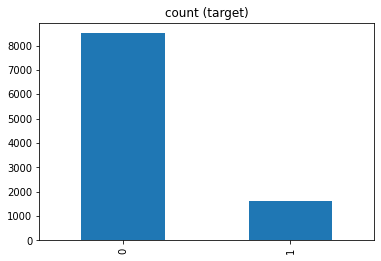

In [133]:
df['Attrition_Flag'].value_counts().plot(kind='bar', title='count (target)')

In [134]:
from sklearn.utils import resample
maxcount = df['Attrition_Flag'].value_counts()[0]
df_resampled = df[0:0]
for grp in df['Attrition_Flag'].unique():
    GrpDF = df[df['Attrition_Flag'] == grp]
    resampled = resample(GrpDF, replace=True, n_samples=int(maxcount), random_state=123)
    df_resampled = df_resampled.append(resampled)

In [135]:
df_resampled['Attrition_Flag'].value_counts()

1    8500
0    8500
Name: Attrition_Flag, dtype: int64

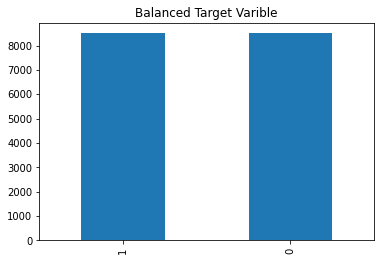

In [136]:
df_resampled['Attrition_Flag'].value_counts().plot(kind='bar', title='Balanced Target Varible')

## Target Column

In [137]:
target = 'Attrition_Flag'
y = df_resampled[target]
X = df_resampled.drop(columns=['Gender','Attrition_Flag','Avg_Open_To_Buy','Income_Category','Education_Level','Dependent_count','Marital_Status','Credit_Limit','Months_on_book','Avg_Utilization_Ratio','Card_Category'])
# X.dtypes

## Spliting Data

In [138]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1,random_state=42)


## Base Line Accuracy

In [139]:
print("Baseline is the frequency of the majority class (most common category):",y_train.value_counts(normalize=True)[0])

Baseline is the frequency of the majority class (most common category): 0.49970951343500364


## Logistic Regression

In [140]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(max_iter =300))

model_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=300,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state

## Random Forest Classifier 

In [141]:
#RandomForest
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                 

## Gradient Boosting

In [142]:
# Gradient Boosting
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier()
)

model_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('gradientboostingclassifier',
                 GradientBoostingClassi...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_sa

## Hyperparameter Tuning

In [143]:
clf = make_pipeline(OrdinalEncoder(),
                    SimpleImputer(),
                    RandomForestClassifier(random_state=42,n_jobs=-1),
                    )
param_grid = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__max_depth':range(20,80,5),
    'randomforestclassifier__n_estimators':range(25,125,25)
}

model = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs = -1,
    cv = 7,
    verbose = 1,
    n_iter = 25
)
model.fit(X_train,y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  2.0min finished


RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


## Evaluation Metrics

In [144]:
print('Logistic Regression Training Accuracy', accuracy_score(y_train, model_lr.predict(X_train)))
print('Logistic Regression Validation Accuracy', accuracy_score(y_val, model_lr.predict(X_val)))

Logistic Regression Training Accuracy 0.8406681190994917
Logistic Regression Validation Accuracy 0.8490196078431372


In [145]:
print('Random Forest Training Accuracy', model_rf.score(X_train, y_train))
print('Random Forest Validation Accuracy', model_rf.score(X_val, y_val))

Random Forest Training Accuracy 1.0
Random Forest Validation Accuracy 0.9908496732026144


In [163]:
print('Gradient Boost Training Accuracy', model_xgb.score(X_train, y_train))
print('Gradient Boost Validation Accuracy', model_xgb.score(X_val, y_val))
print('Gradient Boost Validation Accuracy', model_xgb.score(X_test, y_test))

Gradient Boost Training Accuracy 0.9655773420479303
Gradient Boost Validation Accuracy 0.9647058823529412
Gradient Boost Validation Accuracy 0.9588235294117647


In [147]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.9909223736365477
Best params for `model`: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 55}


## Permutation Importances (Data Leakage)

In [148]:
column = 'Months_Inactive_12_mon'
# It's not that hard to permute (shuffle up the values) a column manually 
X_val_perm = X_val.copy()
X_val_perm[column]=np.random.permutation(X_val_perm[column])
# calculate validation accuracy 

In [149]:
perm_imp = permutation_importance(model_xgb,X_val,y_val,n_jobs=-1,random_state=42)

In [150]:
perm_imp['importances'][:,0:1].sum()

0.5856209150326798

In [151]:
# put this in a dataframe to plot feature importances
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean', ascending=False)

importances['imp_mean']

Total_Trans_Ct              0.298301
Total_Trans_Amt             0.154641
Total_Revolving_Bal         0.039085
Total_Amt_Chng_Q4_Q1        0.029412
Total_Relationship_Count    0.027190
Total_Ct_Chng_Q4_Q1         0.015425
Customer_Age                0.005229
Contacts_Count_12_mon       0.005098
Months_Inactive_12_mon      0.003922
Name: imp_mean, dtype: float64

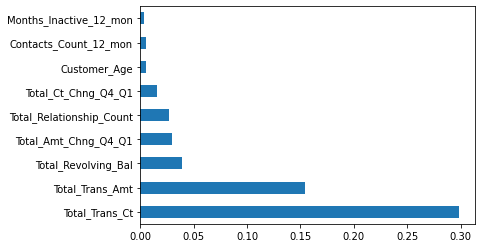

In [152]:
importances['imp_mean'].head(10).plot(kind='barh')

## Accuracy Score,F1 Score, Recall Score

In [153]:
y_pred = model_rf.predict(X_val)

In [154]:
accuracy_score(y_val, y_pred)

0.9908496732026144

In [155]:
f1_score(y_val, y_pred)

0.9909443725743854

In [156]:
recall_score(y_val,y_pred)

1.0

## Classification Report & Confusion Matrix

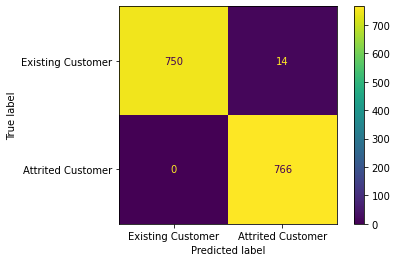

In [157]:
plot_confusion_matrix(
    model_rf,
    X_val, # BE SURE TO USE VALIDATION DATA
    y_val,
    values_format='.0f',
    display_labels=['Existing Customer', 'Attrited Customer']
);

In [158]:
# metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score 
from sklearn.metrics import recall_score, classification_report, roc_auc_score, plot_roc_curve

print(classification_report(y_val, model_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       764
           1       0.98      1.00      0.99       766

    accuracy                           0.99      1530
   macro avg       0.99      0.99      0.99      1530
weighted avg       0.99      0.99      0.99      1530



## Algorithm for Imbalanced Data

In [159]:
# load library
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_val)# check performance
# print('ROCAUC score:',roc_auc_score(y_val, svc_predict))
print('score:',svc_model.score(X_val,y_val))
print('Accuracy score:',accuracy_score(y_val, svc_predict))
print('F1 score:',f1_score(y_val, svc_predict))
print('Accuracy score:',accuracy_score(y_train, svc_model.predict(X_train)))

score: 0.8058823529411765
Accuracy score: 0.8058823529411765
F1 score: 0.7936066712995136
Accuracy score: 0.8106027596223675


## Plotly Dash App

In [160]:
from joblib import dump
dump(model_rf, 'pipeline.joblib', compress=True)


['pipeline.joblib']

In [161]:
# how to download the files from the drive
from google.colab import files 
files.download("pipeline.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [162]:
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==1.0.1
scikit-learn==0.22.2.post1
category_encoders==2.3.0
xgboost==0.90
